In [1]:
import keras
from keras import models, layers
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
import os
from scipy.ndimage import imread
from scipy.misc import imresize
from nbutil import imshow_multi
from PIL import Image
import random

Using TensorFlow backend.


In [2]:
def to_pil(img):
    if img.shape[-1] == 1:
        img = img[:,:,0] # these are grayscale
    return Image.fromarray(np.clip(img * 255, 0, 255).astype(np.uint8))

In [3]:
data_dir = '../data/proj6/data/15SceneData'
categories = [c for c in os.listdir(os.path.join(data_dir, 'train')) if c[0] != '.']

SIZE = 64

def load_dataset(name):
    images = []
    labels = []
    for cat in categories:
        for filename in os.listdir(os.path.join(data_dir, name, cat)):
            if filename.endswith('.jpg'): 
                path = os.path.join(data_dir, name, cat, filename)
                image = imread(path)
                h,w = image.shape[:2]
                # top-left crop
                if h > w:
                    image = image[:w, :]
                else:
                    image = image[:, :h]
                image = imresize(image, size=[SIZE, SIZE], mode='L')
                images.append(image)
                labels.append(categories.index(cat))
    images = np.expand_dims(np.stack(images) / 255.0, -1)
    labels = np.expand_dims(np.stack(labels).astype(int), -1)
    return images, labels

trainx, trainy = load_dataset('train')
testx, testy = load_dataset('test')


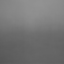

In [4]:
image_gen = ImageDataGenerator(rotation_range=10, 
                               zoom_range=0.2, 
                               width_shift_range=0.15, 
                               height_shift_range=0.15, 
                               horizontal_flip=True,
                               channel_shift_range=0.15)
# samplewise centering is broken in keras (https://github.com/fchollet/keras/issues/4047)
# so do it manually:
mean_img = np.mean(trainx, axis=0)
to_pil(mean_img)

In [5]:
# for x in image_gen.flow(trainx):
#     p = to_pil(x[0])
#     break
# p

In [6]:
input = layers.Input(shape=(SIZE, SIZE, 1))
x = input
y_dim = len(categories)

l2 = keras.regularizers.l2(0.01)

def conv(x, chans, ksize=3):
    return layers.Conv2D(chans, (ksize, ksize), activation='elu', padding='SAME', kernel_regularizer=l2)(x)

for chans, pooling in [(32, 2), (32, 2), (32, 2), (32, 2), (32, 2), (32, 2)]:
    x = conv(x, chans, ksize=3)
    x = conv(x, chans, ksize=1)
    x = layers.AveragePooling2D((pooling, pooling), padding='SAME')(x)
    x = layers.BatchNormalization()(x)
    print(x.shape)

x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(y_dim * 4, activation='elu', kernel_regularizer=l2)(x)
x = layers.Dense(y_dim, activation='softmax', kernel_regularizer=l2)(x)
print(x.shape)
model = models.Model(inputs=[input], outputs=[x])

model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])
model.summary()

(?, 32, 32, 32)
(?, 16, 16, 32)
(?, 8, 8, 32)
(?, 4, 4, 32)
(?, 2, 2, 32)
(?, 1, 1, 32)
(?, 15)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        1056      
_________________________________________________________________
average_pooling2d_1 (Average (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 32)        9248      
______________________________________________

In [7]:
# at epoch 53: loss: 1.3118601918819561, accuracy: 0.6830820771118304

batch_size = 32

for i in range(80):
    lr = 1e-4
    if i > 50:
        lr = 1e-4/2
    model.optimizer.lr.assign(lr)
    model.fit_generator(image_gen.flow(trainx - mean_img, trainy, batch_size=batch_size),
                       steps_per_epoch=len(trainx)/batch_size,
                       verbose=0,
                       workers=2,
                       epochs=1)
    if i % 1 == 0:
        score = model.evaluate(testx - mean_img, testy, verbose=0)
        print('epoch: {}, loss: {}, accuracy: {}'.format(i+1, score[0], score[1]))

epoch: 1, loss: 6.56304867439334, accuracy: 0.07537688442211055
epoch: 2, loss: 6.154905528159597, accuracy: 0.05360134003350084
epoch: 3, loss: 5.7952247605251905, accuracy: 0.05360134003350084
epoch: 4, loss: 5.431676971013822, accuracy: 0.05527638190954774
epoch: 5, loss: 5.206591322274264, accuracy: 0.08676716917922948
epoch: 6, loss: 5.160378462026267, accuracy: 0.05360134003350084
epoch: 7, loss: 4.835272204496553, accuracy: 0.06834170854271357
epoch: 8, loss: 4.889904669181785, accuracy: 0.08777219430485762
epoch: 9, loss: 4.3542019690700515, accuracy: 0.1068676716917923
epoch: 10, loss: 4.171363073856987, accuracy: 0.09313232830820771
epoch: 11, loss: 4.235477644155173, accuracy: 0.06063651591289782
epoch: 12, loss: 4.1098382291682, accuracy: 0.10485762144053601
epoch: 13, loss: 3.3499705605371113, accuracy: 0.21574539363484088
epoch: 14, loss: 3.3028523943532053, accuracy: 0.18425460636515914
epoch: 15, loss: 3.120438038843561, accuracy: 0.23618090452510906
epoch: 16, loss: 2.

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(testx, testy, verbose=0)
print 'accuracy: {}'.format(score[1])